## 章節 4：更多的估計

### 4.3 被淹沒的先驗分佈

一開始我們用均勻分佈當作先驗分佈，但未必是個好選擇。

我可以相信如果硬幣是不公平的，x 可能會偏離 50%，但不太可能比利時的歐元硬幣是不公平到 x=10% 或 x=90%。

所以更可能選擇一個先驗分佈，有較高的機率當 x 接近 50%，較小的低率出現在極端值。

參考以下個程式碼，我用一個三角形的先驗分佈來代替均勻分佈。

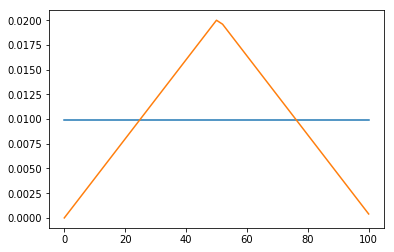

In [27]:
from thinkbayes import Suite, Percentile
import matplotlib.pyplot as plt

class Euro_Uniform(Suite):
    
    def Likelihood(self, data, hypo):
        if data == 'H':
            return hypo/100.0
    
        return 1-hypo/100.0
    
class Euro_Triangular(Euro_Uniform):
    
    def __init__(self, hypos):
        super().__init__()
        size = len(hypos)
        half = size//2+1
        
        # 三角形先驗分佈
        for i in range(half):
            self.Set(hypos[i], i)
        
        for i in range(half+1, size):
            self.Set(hypos[i], size-i)

        self.Normalize()

def plot_suite(suite):
    x, y = zip(*sorted(suite.Items()))
    plt.plot(x, y)
        

hypos = range(101)
suite1 = Euro_Uniform(hypos)
suite2 = Euro_Triangular(hypos)

plot_suite(suite1)
plot_suite(suite2)
plt.show()

上圖顯示

- 藍色線條為均勻先驗分佈
- 橘色線條為三角形先驗分佈

接下來觀察看到資料後的後驗分佈

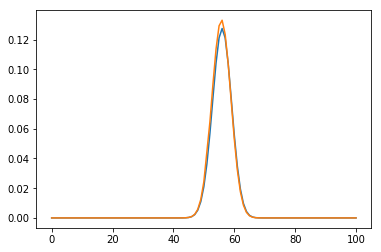

藍色後驗分佈平均值： 55.952380952380956
橘色後驗分佈平均值： 55.95450986075134


In [28]:
def update_distribution(suite, dataset):
    for data in dataset:
        suite.Update(data)


head, tail = 140, 110 # 依據問題出現 140 次正面、110次反面
dataset = 'H' * head + 'T' * tail # 觀察到的資料，不考慮順序

update_distribution(suite1, dataset)
update_distribution(suite2, dataset)
plot_suite(suite1)
plot_suite(suite2)
plt.show()

print("藍色後驗分佈平均值：", suite1.Mean())
print("橘色後驗分佈平均值：", suite2.Mean())

觀察上圖發現不同的先驗分佈，在看到數據後出現**相似的**後驗分佈。

上述便是一個被淹沒的先驗分佈的例子（swamping the priors）：有足夠的資料下，即使不同的先驗分佈，最後會傾向於收斂到相同的後驗分佈(**不必然會發生**)。